# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs! 

In this document you will work through a similar process that we did in class with the NBA data (NBA_Perf_22 and nba_salaries_22), merging them together.

Details: 

- Determine a way to use clustering to estimate based on performance if 
players are under or over paid, generally. 

- Then select players you believe would be best for your team and explain why. Do so in three categories: 
    * Examples that are not good choices (3 or 4) 
    * Several options that are good choices (3 or 4)
    * Several options that could work, assuming you can't get the players in the good category (3 or 4)

- You will decide the cutoffs for each category, so you should be able to explain why you chose them.

- Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations. 


Hints:

- Salary is the variable you are trying to understand 
- When interpreting you might want to use graphs that include variables that are the most correlated with Salary
- You'll need to scale the variables before performing the clustering
- Be specific about why you selected the players that you did, more detail is better
- Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used. 
- Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import plotly.express as px
from sklearn.metrics import silhouette_score


## Reading, Merging, and Cleaning Data

Reading in each dataframe:

In [2]:
#help(pd.read_csv)
stats = pd.read_csv("nba_2025.txt", encoding = "latin-1")   # separator arguement defails to commas, which works in this text file
stats.info()

<class 'pandas.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 642 non-null    float64
 1   Player             643 non-null    str    
 2   Age                642 non-null    float64
 3   Team               642 non-null    str    
 4   Pos                642 non-null    str    
 5   G                  642 non-null    float64
 6   GS                 642 non-null    float64
 7   MP                 642 non-null    float64
 8   FG                 642 non-null    float64
 9   FGA                642 non-null    float64
 10  FG%                637 non-null    float64
 11  3P                 642 non-null    float64
 12  3PA                642 non-null    float64
 13  3P%                595 non-null    float64
 14  2P                 642 non-null    float64
 15  2PA                642 non-null    float64
 16  2P%                631 non-null    fl

In [3]:
salaries = pd.read_csv("2025_salaries.csv", encoding = "latin-1")
salaries.head()

,ï»¿,Unnamed: 1,Salary
0,Player,Tm,2025-26
1,Jaden Springer,NOP,"$70,732"
2,Garrison Mathews,IND,"$131,970"
3,Garrison Mathews,IND,"$131,970"
4,Mac McClung,IND,"$164,060"


For some reason the first row appears to be the columns names, so let's ensure the columns are properly named before merging:

In [4]:
salaries.columns = ["Player", "Team", "Salary, 2025-2026"]
# Drop the first row
salaries.drop(index=0, inplace=True)   # inplace just modifies the original dataframe without making a new one

salaries.head()

,Player,Team,"Salary, 2025-2026"
1,Jaden Springer,NOP,"$70,732"
2,Garrison Mathews,IND,"$131,970"
3,Garrison Mathews,IND,"$131,970"
4,Mac McClung,IND,"$164,060"
5,Didi Louzada,POR,"$268,032"


Now we meed to merge the two dataframes so that the salary informaiton can be included with the first dataframe will all the other statistics. The .merge function below merges on the "Player" column for both datasets, and adds the features associated with each dataset into one dataset. So it only will take over players that are in both the stats and salaries datasets.

In [5]:
# help(pd.merge)
df = pd.merge(stats, salaries, on = "Player", how = "inner")
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 524 non-null    float64
 1   Player             524 non-null    str    
 2   Age                524 non-null    float64
 3   Team_x             524 non-null    str    
 4   Pos                524 non-null    str    
 5   G                  524 non-null    float64
 6   GS                 524 non-null    float64
 7   MP                 524 non-null    float64
 8   FG                 524 non-null    float64
 9   FGA                524 non-null    float64
 10  FG%                523 non-null    float64
 11  3P                 524 non-null    float64
 12  3PA                524 non-null    float64
 13  3P%                494 non-null    float64
 14  2P                 524 non-null    float64
 15  2PA                524 non-null    float64
 16  2P%                521 non-null    fl

Looks like the team column is listed twice since it's in both dataframes but is not the column we joined on. Let's drop one of them to reduce complexity.

In [6]:
df = df.drop("Team_y", axis=1)

Renaming "Team_x" to just "Team"

In [7]:
df.rename(columns={'Team_x': 'Team'} ,inplace=True)
df.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional,"Salary, 2025-2026"
0,1.0,Shai Gilgeous-Alexander,27.0,OKC,PG,49.0,49.0,1632.0,534.0,964.0,...,314.0,64.0,38.0,103.0,101.0,1558.0,0.0,NaN,gilgesh01,"$38,333,050"
1,2.0,Tyrese Maxey,25.0,PHI,PG,52.0,52.0,2008.0,524.0,1117.0,...,351.0,102.0,40.0,126.0,118.0,1503.0,0.0,NaN,maxeyty01,"$37,958,760"
2,3.0,Donovan Mitchell,29.0,CLE,SG,51.0,51.0,1719.0,516.0,1060.0,...,302.0,79.0,15.0,159.0,125.0,1478.0,0.0,NaN,mitchdo01,"$46,394,100"
3,4.0,Jaylen Brown,29.0,BOS,SF,49.0,49.0,1676.0,534.0,1105.0,...,229.0,49.0,20.0,176.0,136.0,1435.0,2.0,NaN,brownja02,"$53,142,264"
4,6.0,Jalen Brunson,29.0,NYK,PG,50.0,50.0,1728.0,481.0,1024.0,...,305.0,36.0,5.0,110.0,116.0,1351.0,0.0,NaN,brunsja01,"$34,944,001"


However, before continuing, it must be pointed out that there are duplicate entries in the merged dataset. This can be seen since there are 643 rows in the stats dataset, 471 in the salaries dataset, but the merged data is greater than 471 at 524 entries. This happens because some players move to different teams durnig the season, so the data uses mulitple entries per team to track their stats.

Let's examine what the duplicates are:

In [8]:
# Indexing the dataframe with subset of df creates a new duplicates dataframe
duplicates = df[df.duplicated(subset="Player", keep = False)]  
duplicates

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional,"Salary, 2025-2026"
11,13.0,James Harden,36.0,2TM,PG,47.0,47.0,1656.0,338.0,804.0,...,384.0,58.0,20.0,173.0,90.0,1176.0,2.0,NaN,hardeja01,"$39,182,693"
12,13.0,James Harden,36.0,LAC,PG,44.0,44.0,1559.0,323.0,771.0,...,358.0,57.0,16.0,162.0,83.0,1118.0,2.0,NaN,hardeja01,"$39,182,693"
13,13.0,James Harden,36.0,CLE,PG,3.0,3.0,97.0,15.0,33.0,...,26.0,1.0,4.0,11.0,7.0,58.0,0.0,NaN,hardeja01,"$39,182,693"
36,37.0,CJ McCollum,34.0,2TM,SG,51.0,37.0,1537.0,354.0,778.0,...,182.0,38.0,19.0,87.0,99.0,957.0,0.0,NaN,mccolcj01,"$30,666,666"
37,37.0,CJ McCollum,34.0,WAS,SG,35.0,35.0,1082.0,240.0,529.0,...,126.0,24.0,9.0,58.0,73.0,658.0,0.0,NaN,mccolcj01,"$30,666,666"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,496.0,Charles Bassey,25.0,MEM,C,2.0,0.0,31.0,3.0,8.0,...,2.0,1.0,1.0,1.0,5.0,7.0,0.0,NaN,bassech01,NaN
515,496.0,Charles Bassey,25.0,PHI,C,1.0,0.0,5.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.0,NaN,bassech01,NaN
518,515.0,Isaac Jones,25.0,2TM,PF,4.0,1.0,18.0,2.0,4.0,...,1.0,0.0,0.0,0.0,4.0,5.0,0.0,NaN,jonesis01,"$1,955,377"
519,515.0,Isaac Jones,25.0,SAC,PF,3.0,1.0,17.0,1.0,2.0,...,1.0,0.0,0.0,0.0,4.0,3.0,0.0,NaN,jonesis01,"$1,955,377"


Below shows that there are 56 players that have duplicates entries, so we need a way to only pull one entry for each player.

In [9]:
duplicates["Player"].unique()

<StringArray>
[          'James Harden',            'CJ McCollum',      'Jaren Jackson Jr.',
        'Anfernee Simons',            'Ayo Dosunmu',          'Collin Sexton',
        'Duncan Robinson',        'De'Andre Hunter',          'Deandre Ayton',
           'Jock Landale',     'Bennedict Mathurin',          'Kevin Huerter',
             'Vit Krejci',        'Jordan Clarkson',           'Marcus Smart',
             'Cam Thomas',      'Marvin Bagley III',           'Luke Kennard',
        'Khris Middleton',          'Jose Alvarado',            'Buddy Hield',
          'Corey Kispert',         'Walter Clayton',             'Jaden Ivey',
     'Vince Williams Jr.',           'Jared McCain',             'Keon Ellis',
         'Isaiah Jackson',            'Jaden Hardy',           'Cole Anthony',
       'Taylor Hendricks',           'Ochai Agbaji',          'Kyle Anderson',
   'Trayce Jackson-Davis',     'Guerschon Yabusele',         'Rob Dillingham',
             'Tyus Jones',           '

Since there are 166 rows in the duplicates dataset and 56 unique players, we need to create a dataframe with 524  - (166-56) = 414 player entries.

In [10]:
df = df.loc[df.groupby("Player")["G"].idxmax()]
# Let's unpack this line above:
# - df.groupby("Player") groups dataframe by each unique player name
# - adding the ["G"] specifies to only look at games played for each unique player
# - .idxmax() returns the index of the row where the max value occurs in each group
# - df.loc[] selects the rows with those indices
# Although we only are dealing with duplicates, this code goes through each player 
# in the dataframe (the ones without duplicates are already have the max games played
# in their "group."")

# Sorting Index
df = df.sort_index()
df

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional,"Salary, 2025-2026"
0,1.0,Shai Gilgeous-Alexander,27.0,OKC,PG,49.0,49.0,1632.0,534.0,964.0,...,314.0,64.0,38.0,103.0,101.0,1558.0,0.0,NaN,gilgesh01,"$38,333,050"
1,2.0,Tyrese Maxey,25.0,PHI,PG,52.0,52.0,2008.0,524.0,1117.0,...,351.0,102.0,40.0,126.0,118.0,1503.0,0.0,NaN,maxeyty01,"$37,958,760"
2,3.0,Donovan Mitchell,29.0,CLE,SG,51.0,51.0,1719.0,516.0,1060.0,...,302.0,79.0,15.0,159.0,125.0,1478.0,0.0,NaN,mitchdo01,"$46,394,100"
3,4.0,Jaylen Brown,29.0,BOS,SF,49.0,49.0,1676.0,534.0,1105.0,...,229.0,49.0,20.0,176.0,136.0,1435.0,2.0,NaN,brownja02,"$53,142,264"
4,6.0,Jalen Brunson,29.0,NYK,PG,50.0,50.0,1728.0,481.0,1024.0,...,305.0,36.0,5.0,110.0,116.0,1351.0,0.0,NaN,brunsja01,"$34,944,001"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,501.0,Dillon Jones,24.0,NYK,SF,4.0,0.0,21.0,1.0,5.0,...,3.0,2.0,0.0,0.0,3.0,7.0,0.0,NaN,jonesdi01,"$2,753,280"
518,515.0,Isaac Jones,25.0,2TM,PF,4.0,1.0,18.0,2.0,4.0,...,1.0,0.0,0.0,0.0,4.0,5.0,0.0,NaN,jonesis01,"$1,955,377"
521,518.0,Garrett Temple,39.0,TOR,SG,13.0,0.0,36.0,1.0,7.0,...,4.0,3.0,1.0,3.0,3.0,4.0,0.0,NaN,templga01,"$2,296,274"
522,519.0,N'Faly Dante,24.0,ATL,C,4.0,0.0,15.0,1.0,4.0,...,0.0,2.0,0.0,1.0,1.0,3.0,0.0,NaN,nfalyda01,"$2,048,494"


Perfect! 414 rows means that we only have unique players in the dataset.

Now let's drop variables that likely won't be needed for our clustering model:

- Age: we care more about performance metrics
- G: time played is already covered by minutes played
- GS: time played is already covered by minutes played
- Rk: just an index
- Player: label (categorical)
- Team: categorical
- Pos: categorical
- Awards: has missing values, and is also subjective
- Trp-Dbl: triple doubles are skewed toward top players --> would make it hard to find undervalued players which is what we're trying to do
- FG: already have FGA and FG%
- 2P: already have 2PA and 2P%
- 3P: already have 3PA and 3P%
- FT: already have FTA and FT%
- TB: rebounds already covered by ORB and DRB

Even though the player column is categorical, I will keep it in the dataframe (but not in the performance features) so it can be used as an indicator for when we create a final plot that includes salary as a color.

In [11]:
columns_to_drop = ["Age", "G", "GS", "Rk", "Team", "Pos", "Awards", "Player-additional", "Trp-Dbl", "FG", "2P", "3P", "FT", "TRB"]
df = df.drop(columns = columns_to_drop)
df.info()

<class 'pandas.DataFrame'>
Index: 414 entries, 0 to 523
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             414 non-null    str    
 1   MP                 414 non-null    float64
 2   FGA                414 non-null    float64
 3   FG%                414 non-null    float64
 4   3PA                414 non-null    float64
 5   3P%                394 non-null    float64
 6   2PA                414 non-null    float64
 7   2P%                413 non-null    float64
 8   eFG%               414 non-null    float64
 9   FTA                414 non-null    float64
 10  FT%                411 non-null    float64
 11  ORB                414 non-null    float64
 12  DRB                414 non-null    float64
 13  AST                414 non-null    float64
 14  STL                414 non-null    float64
 15  BLK                414 non-null    float64
 16  TOV                414 non-null    float64

Now let's check for missing values in the data:

In [12]:
df.isna().sum()

Player                0
MP                    0
FGA                   0
FG%                   0
3PA                   0
3P%                  20
2PA                   0
2P%                   1
eFG%                  0
FTA                   0
FT%                   3
ORB                   0
DRB                   0
AST                   0
STL                   0
BLK                   0
TOV                   0
PF                    0
PTS                   0
Salary, 2025-2026     3
dtype: int64

Looks like some columns have missing values, so let's check why they are present by looking at only the rows with missing values:

In [13]:
df[df.isna().any(axis=1)].head(10)

,Player,MP,FGA,FG%,3PA,3P%,2PA,2P%,eFG%,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,"Salary, 2025-2026"
68,Jalen Duren,1218.0,480.0,0.631,0.0,NaN,480.0,0.631,0.631,232.0,0.737,162.0,296.0,77.0,40.0,34.0,83.0,125.0,777.0,"$6,483,144"
114,Ivica Zubac,1328.0,429.0,0.613,0.0,NaN,429.0,0.613,0.613,132.0,0.705,148.0,325.0,96.0,16.0,36.0,82.0,104.0,619.0,"$18,102,000"
121,Deandre Ayton,1299.0,412.0,0.675,0.0,NaN,412.0,0.675,0.675,82.0,0.646,117.0,272.0,41.0,29.0,44.0,63.0,107.0,609.0,"$43,654,814"
261,Luke Kornet,1006.0,197.0,0.655,0.0,NaN,197.0,0.655,0.655,82.0,0.793,133.0,160.0,86.0,21.0,54.0,19.0,84.0,323.0,"$11,000,000"
272,Daniel Gafford,814.0,185.0,0.632,0.0,NaN,185.0,0.632,0.632,94.0,0.755,81.0,166.0,35.0,29.0,51.0,50.0,100.0,305.0,"$14,386,320"
327,Jakob Poeltl,551.0,134.0,0.687,0.0,NaN,134.0,0.687,0.687,49.0,0.592,59.0,109.0,45.0,16.0,11.0,34.0,68.0,213.0,"$19,500,000"
344,Mitchell Robinson,766.0,119.0,0.697,0.0,NaN,119.0,0.697,0.697,71.0,0.408,176.0,170.0,38.0,31.0,45.0,25.0,92.0,195.0,"$12,954,546"
353,Steven Adams,730.0,139.0,0.504,0.0,NaN,139.0,0.504,0.504,81.0,0.580,145.0,131.0,48.0,22.0,20.0,35.0,55.0,187.0,"$14,130,434"
361,Clint Capela,556.0,144.0,0.528,0.0,NaN,144.0,0.528,0.528,38.0,0.553,101.0,112.0,26.0,24.0,37.0,19.0,40.0,173.0,"$6,700,000"
388,Jericho Sims,613.0,78.0,0.821,0.0,NaN,78.0,0.821,0.821,23.0,0.652,54.0,112.0,32.0,8.0,9.0,37.0,70.0,143.0,"$2,461,463"


It appears that missing values are present because a player hasn't attempted a specific performance metric. For example, if someone has 0 three point attempts, then their three point percentage is a missing value. 

Let's change that by filling the missing values with 0, but first we need to drop the rows with a missing value for salary since that is the variable we are trying to analyze.

In [14]:
df = df.dropna(subset=["Salary, 2025-2026"])

Filling missing values with 0:

In [15]:
df = df.fillna(0)

Check:

In [16]:
df.isna().sum()

Player               0
MP                   0
FGA                  0
FG%                  0
3PA                  0
3P%                  0
2PA                  0
2P%                  0
eFG%                 0
FTA                  0
FT%                  0
ORB                  0
DRB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
PTS                  0
Salary, 2025-2026    0
dtype: int64

Lastly, let's make salary a numeric column (and rename it to just "Salary"):

In [17]:
df["Salary, 2025-2026"] = (
    df["Salary, 2025-2026"]
    .str.replace("$", "", regex=False)  # regex ensures the first character ($ or ,) is treated as a string character and nothing more
    .str.replace(",", "", regex=False)
    .astype(float)
)

Here's what our dataframe looks like now:

In [18]:
df.head()

,Player,MP,FGA,FG%,3PA,3P%,2PA,2P%,eFG%,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,"Salary, 2025-2026"
0,Shai Gilgeous-Alexander,1632.0,964.0,0.554,223.0,0.390,741.0,0.603,0.599,452.0,0.892,27.0,191.0,314.0,64.0,38.0,103.0,101.0,1558.0,38333050.0
1,Tyrese Maxey,2008.0,1117.0,0.469,459.0,0.379,658.0,0.532,0.547,316.0,0.889,14.0,200.0,351.0,102.0,40.0,126.0,118.0,1503.0,37958760.0
2,Donovan Mitchell,1719.0,1060.0,0.487,492.0,0.376,568.0,0.583,0.574,306.0,0.853,41.0,188.0,302.0,79.0,15.0,159.0,125.0,1478.0,46394100.0
3,Jaylen Brown,1676.0,1105.0,0.483,293.0,0.348,812.0,0.532,0.529,342.0,0.775,57.0,279.0,229.0,49.0,20.0,176.0,136.0,1435.0,53142264.0
4,Jalen Brunson,1728.0,1024.0,0.470,390.0,0.374,634.0,0.528,0.541,287.0,0.847,26.0,140.0,305.0,36.0,5.0,110.0,116.0,1351.0,34944001.0


## Selecting Performance Metrics and Scaling

We can't have salary when we fit the model to the performance features, so we need to get rid of it for now:

In [19]:
# Select performance variables for clustering (NOT salary)
features = [
    "MP", "FGA", "FG%", "3PA", "3P%", "2PA", "2P%", "eFG%", "FTA", "FT%",
    "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"
]

pf_metrics = df[features]


Now we scale the data:

In [20]:
# Keeping it a dataframe (columns restores column names, index restores original player index so stats are lined up)
pf_metrics = pd.DataFrame(MinMaxScaler().fit_transform(pf_metrics), columns=features, index=df.index)
pf_metrics.describe()

,MP,FGA,FG%,3PA,3P%,2PA,2P%,eFG%,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,0.433497,0.289640,0.564029,0.275483,0.321112,0.234140,0.537808,0.653710,0.190405,0.757326,0.165979,0.256375,0.210898,0.279828,0.164211,0.280885,0.389133,0.270980
std,0.258574,0.220554,0.110653,0.234253,0.133118,0.202994,0.106189,0.101913,0.188584,0.138416,0.152137,0.188582,0.192064,0.193909,0.175515,0.220429,0.230648,0.213242
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.216783,0.112657,0.507917,0.075203,0.299500,0.073892,0.498000,0.609013,0.057522,0.698500,0.059426,0.104626,0.068584,0.119266,0.047170,0.106742,0.207182,0.099807
50%,0.434565,0.245063,0.554202,0.229675,0.346000,0.173645,0.538000,0.652862,0.128319,0.778000,0.122951,0.233480,0.157080,0.256881,0.103774,0.235955,0.397790,0.224005
75%,0.641359,0.422352,0.609013,0.423780,0.382500,0.355911,0.593000,0.707065,0.261062,0.846000,0.227459,0.364537,0.295354,0.385321,0.216981,0.401685,0.560773,0.394416
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Clustering Model

Let's first understand what a clustering model does. We have a bunch of data points from the performance metrics above, and we want to group them together so that data points of similar characteristics are together. To do this, the model first picks random centroids, which are the cluster centers. The model then assigns points to clusters depending on the distance between the point and the centroid. After the points are separated into their respective clusters, the model then moves the centroids again to represent the average data point in the cluster. Since the centroids have moved, the model then repeats the process of assiging points to the closest centroid, clustering, and moving the centroids again. The model will repeat these steps until the centroids stop moving.

Now we let's create a clustering model; I will first choose a k-value of 3 as my guess:

In [21]:
# Creating the kmeans object type, no model just yet
model = KMeans(n_clusters = 3, random_state=83, verbose = 1)

# Fitting model to the data:
model.fit(pf_metrics)

Initialization complete
Iteration 0, inertia 164.1924668575876.
Iteration 1, inertia 115.29204267513201.
Iteration 2, inertia 112.8238162921999.
Iteration 3, inertia 111.93408002115532.
Iteration 4, inertia 111.51950095276003.
Iteration 5, inertia 111.12018062937614.
Iteration 6, inertia 110.4472188643808.
Iteration 7, inertia 109.83482493041869.
Iteration 8, inertia 109.47076824496716.
Iteration 9, inertia 109.39732920435108.
Iteration 10, inertia 109.39471175387264.
Converged at iteration 10: strict convergence.


,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",3
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",1
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",83
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


It looks like the model stops after 10 iterations --> that's when the centroids stop moving

It's important to know what the "inertia" values mean to the model. It's essentially a metric used to describe how close the points in a cluster are to their respective centroid. Since squared distances are easier to work with, the intertia value is the within-cluster sum of sqaured distances of points to their cluster centroid. A smaller inertia means the data points in a cluster are closer together.

Let's review the results by looking at the cluster centers and labels:

In [22]:
# Coordinates of Cluster Centers:
print("Cluster Centers: \n")
print(model.cluster_centers_ ,"\n")

# Cluster Labels for each Observation:
print("Cluster Labels: \n")
print(model.labels_, "\n")

# Within-cluster sum of squares distance:
print("Within-cluster sum of squares (WCSS):")
print(model.inertia_)


Cluster Centers: 

[[0.75218899 0.58893935 0.58486781 0.50255061 0.34051961 0.50717183
  0.54362745 0.6671085  0.43592747 0.79079412 0.2616522  0.47989548
  0.44121985 0.47247706 0.29513504 0.58030403 0.63059257 0.56290116]
 [0.1506528  0.07947131 0.53698181 0.08543594 0.2933931  0.06095634
  0.52013103 0.62478055 0.04540738 0.72257931 0.06571509 0.08324472
  0.0566982  0.0924391  0.05172414 0.08264239 0.15160983 0.07078925]
 [0.4853622  0.28931121 0.57498292 0.30228782 0.33354878 0.21744713
  0.54981707 0.67095452 0.16590222 0.76723171 0.19512195 0.27042817
  0.203985   0.32568807 0.18223654 0.26993697 0.4489624  0.26641802]] 

Cluster Labels: 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0
 0 2 0 2 0 0 2 0 0 0 0 0 2 0 2 2 0 0 2 0 0 0 0 2 2 0 2 0 2 0 2 0 2 0 2 2 0
 2 2 2 2 2 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 0 0 2 2 0 2 2 2 2 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

Before visualizing, we need to add the cluster labels to the dataframe:

In [23]:
df["Cluster Label"] = model.labels_
df.head()

,Player,MP,FGA,FG%,3PA,3P%,2PA,2P%,eFG%,FTA,...,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,"Salary, 2025-2026",Cluster Label
0,Shai Gilgeous-Alexander,1632.0,964.0,0.554,223.0,0.390,741.0,0.603,0.599,452.0,...,27.0,191.0,314.0,64.0,38.0,103.0,101.0,1558.0,38333050.0,0
1,Tyrese Maxey,2008.0,1117.0,0.469,459.0,0.379,658.0,0.532,0.547,316.0,...,14.0,200.0,351.0,102.0,40.0,126.0,118.0,1503.0,37958760.0,0
2,Donovan Mitchell,1719.0,1060.0,0.487,492.0,0.376,568.0,0.583,0.574,306.0,...,41.0,188.0,302.0,79.0,15.0,159.0,125.0,1478.0,46394100.0,0
3,Jaylen Brown,1676.0,1105.0,0.483,293.0,0.348,812.0,0.532,0.529,342.0,...,57.0,279.0,229.0,49.0,20.0,176.0,136.0,1435.0,53142264.0,0
4,Jalen Brunson,1728.0,1024.0,0.470,390.0,0.374,634.0,0.528,0.541,287.0,...,26.0,140.0,305.0,36.0,5.0,110.0,116.0,1351.0,34944001.0,0


Now let's visualize the results, using total minutes played (MP) and total points (PTS) as the feature variables. 

We aren't going to dive into the salary variable yet; we're just trying to examine our model and see how well it can differentiate clusters, so that we can best analyze salary later to pick underpaid players for our team.

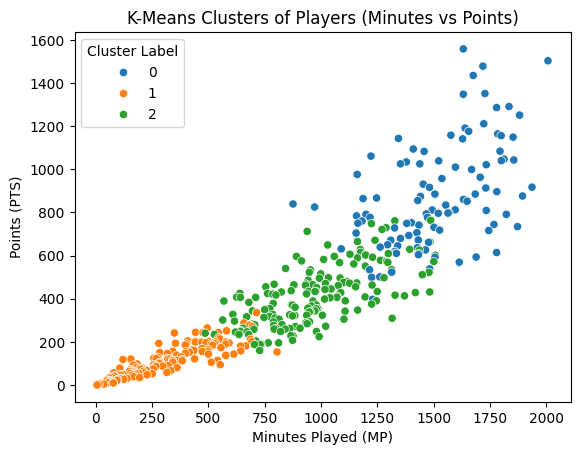

In [24]:
sns.scatterplot(df, x="MP", y="PTS", hue="Cluster Label", palette = "tab10")
plt.title("K-Means Clusters of Players (Minutes vs Points)")
plt.xlabel("Minutes Played (MP)")
plt.ylabel("Points (PTS)")
plt.show()

It looks like the clusters are pretty well defined!

Let's also see what a 3d plot would look like by adding in a third variable, three point percentage (3P%)

In [25]:
fig = px.scatter_3d(
    df,
    x="MP",
    y="PTS",
    z="3P%",
    color=df["Cluster Label"].astype(str),  # color by cluster
    title="K-Means Clusters of NBA Players"
)

fig.show()
   

Again, the clusters are pretty differentiated.

## Evaluating Model 

### Variance Explained

First we'll use the total variance explained method.

We start by calculating the total sum of squared (TSS) distances from each point to the overall mean. We're looking at the total spread about the mean.

In [26]:
total_sum_squares = np.sum((pf_metrics - np.mean(pf_metrics))**2)
total = np.sum(total_sum_squares)
print(f"Total Sum of Squares (TSS): {total}")

Total Sum of Squares (TSS): 467.1991470018356


Now we must calculate the between-cluster sum of squares (BSS)

BSS = TSS - WCSS (inertia)

BSS measures variance BETWEEN clusters (how separated they are)

WCSS (inertia) measures variance WITHIN clusters (how tight they are)

In [27]:
between_SSE = (total - model.inertia_)
print(f"Between-Cluster Sum of Squares (BSS): {between_SSE}")

Between-Cluster Sum of Squares (BSS): 357.804435247963


Finally we get the variance explained value:

Variance Explained = BSS / TSS

Higher is better (means clusters capture meaningful patterns)

Range: 0 to 1, where 1 = perfect clustering

In [28]:
var_explained = between_SSE / total
print(f"Variance Explained: {var_explained:.4f} or {var_explained*100:.2f}%")

Variance Explained: 0.7658 or 76.58%


76.58% variance isn't bad! This means the clustering model explains 76.58% of the variance in player performance stats, indicating that the clusters are successfully differentiated from one another and grouped players together with similar stats. 

### Silhouette Scores

Now we'll use the silhouette scores method to evaluate the clustering model when there are 3 clusters. Silhouette scores measures how similar a point is to its own cluster versus how similar it is to the nearest other cluster. 

The range of output is -1 to 1:
- 1 = perfect clustering (points very close to own cluster)
- 0 = point on border of two clusters
- -1 = point likely assigned to wrong cluster


In [29]:
sil_score = silhouette_score(pf_metrics, model.labels_)
print(f"Silhouette Score for k=3: {sil_score:.4f}")

Silhouette Score for k=3: 0.2783


A silhouette score of 0.2783 illustrates that clusters are meaningful, but include some points that are on the border of two groups. Although this seems bad, this is actually what we want, since players that have a good performance on the court and have a smaller salary then other similar-performance players are our ideal targets. Unclear borders is exactly what we need to choose our players.

## Ideal Number of Clusters

First we will use the elbow method to find the ideal amount of clusters we should use. We will calculate the within-cluster sum of squares (the inertia) which measures the total distance of points from their cluster centers. We'll do this for each value of k from 1 to 10.

In [30]:
# Initializing 
wcss = []
k_values = range(1, 11)

# Looping through each k and adding the inertia value to the list
for k in k_values:
    model = KMeans(n_clusters=k, random_state=83).fit(pf_metrics)
    wcss.append(model.inertia_)

Now we want to plot the wcss value for each k and look for the "elbow." The elbow is the point on the curve where adding more clusters doesn't help as much. In economic terms, it's the point the starts the dimininishing returns of adding more clusters. 

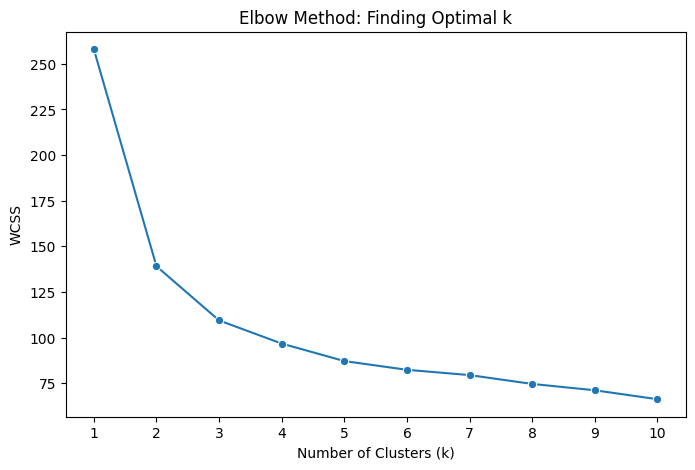

In [31]:
# Creating a dataframe to be plotted
elbow_data = pd.DataFrame({
    "k": k_values,
    "wcss": wcss
})

# Plotting elbow curve
plt.figure(figsize=(8, 5))
sns.lineplot(elbow_data, x="k", y="wcss", marker="o")


plt.xticks(k_values)
plt.title("Elbow Method: Finding Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")

plt.show()

Looking at the graph, it appears that the elbow occurs at either k = 2 or k = 3. There is a significant decrease in the wcss value from 1 to 2 clusters and a smaller but still decent decrease from 2 to 3 clusters. However, adding more clusters after 3 don't give as much of a valuable decrease in inertia. There's no need to increase the complexity of the model when the benefit isn't as great. 

Now let's use silhoutte scores for different values of k:

In [32]:
# Initialize
silhouette_scores = []
k_values = range(2, 11)    # silhoutte scores need at least 2 clusters

# Loop through k values and add to list
for k in k_values:
    model = KMeans(n_clusters=k, random_state=83).fit(pf_metrics)
    
    score = silhouette_score(pf_metrics, model.labels_)
    silhouette_scores.append(score)

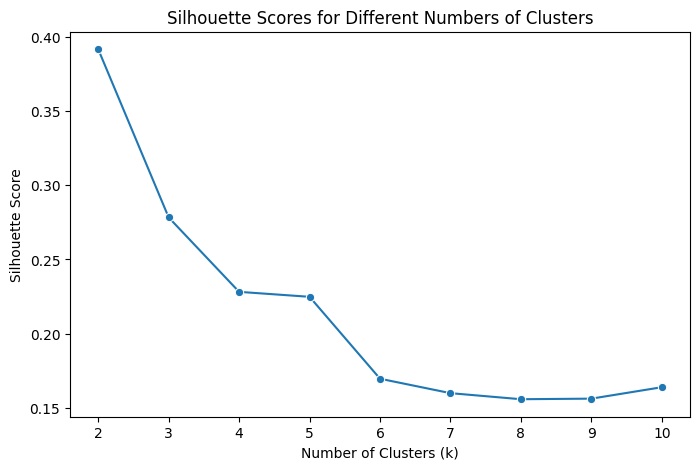

In [33]:
# Putting results in a dataframe like before
silhouette_df = pd.DataFrame({
    "k": k_values,
    "silhouette_score": silhouette_scores
})


# Create the line plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=silhouette_df,
    x="k",
    y="silhouette_score",
    marker="o"
)


plt.xticks(k_values)
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.show()

k = 2 has the highest silhoutte score, but that shouldn't be the prime indicator  of the ideal cluster amount. 3 clusters should be the best for choosing underpaid players for our team since for one, there is still a decent drop in the inertia (WCSS) from 2 to 3 clusters, and also having a lower silhoutte score can help us find high performing players that are paid less since they will be on the border of clusters or look like outliers from their own cluster centers.

## Preparation to Choose Underpaid Players

Now we need to create a visualization that measures performance the best, and then add the salary variable as a color to see which players we should obtain.

We tried points and minutes played before, but some of the underpaid players in the NBA probably don't play that much so we want two metrics that measure performance such that the top right of the graph are elite players and the bottom left are not-the-best players.

Let's start with points and 3 point percentage:

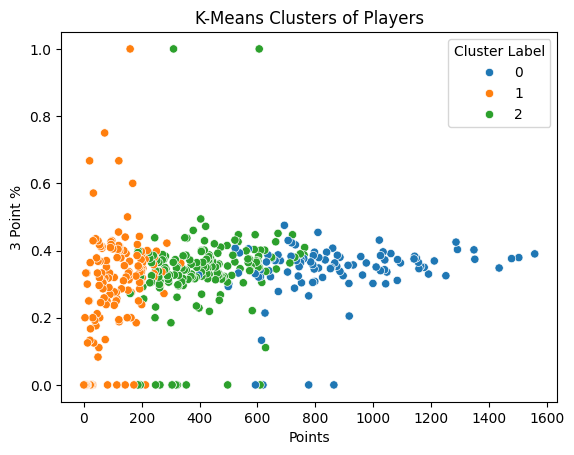

In [34]:
sns.scatterplot(df, x="PTS", y="3P%", hue="Cluster Label", palette = "tab10")
plt.title("K-Means Clusters of Players")
plt.xlabel("Points")
plt.ylabel("3 Point %")
plt.show()

This plot doesn't give us much information because a lot of the players are in a similar range of 3 point shooting, and the players with high 3 point percentages don't play as much (smaller sample size).

How about points and effective field goal percentage?

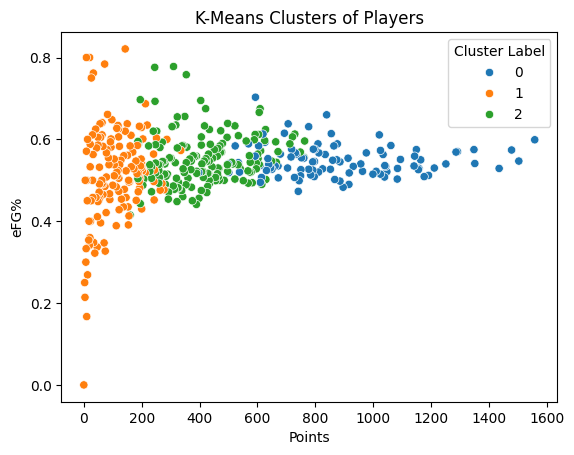

In [35]:
sns.scatterplot(df, x="PTS", y="eFG%", hue="Cluster Label", palette = "tab10")
plt.title("K-Means Clusters of Players")
plt.xlabel("Points")
plt.ylabel("eFG%")
plt.show()

Again, not very spread out.

Points and assists? The NBA is increasingly more and more about scoring than anything else so scoring and helping others score seems like a reasonable choice.

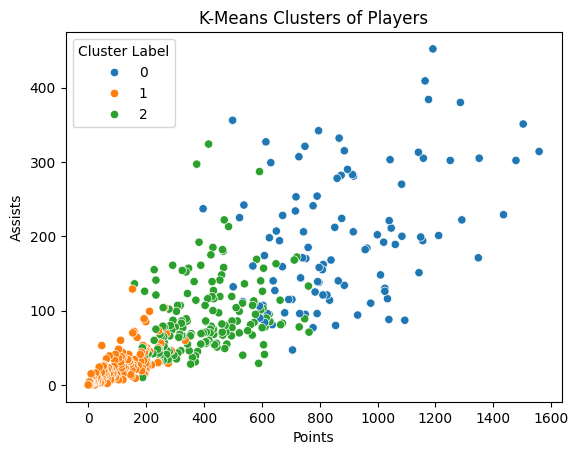

In [36]:
sns.scatterplot(df, x="PTS", y="AST", hue="Cluster Label", palette = "tab10")
plt.title("K-Means Clusters of Players")
plt.xlabel("Points")
plt.ylabel("Assists")
plt.show()

Looks good! 

Now we're ready to add the salary variable and make decisions on who we want on our team. Let's create a plot that allows us to hover over data points to see which player it is. We're looking for players in the top right with low salaries.

In [37]:
fig = px.scatter(
    df,
    x="PTS",
    y="AST",
    color="Salary, 2025-2026",                 # continuous gradient
    symbol="Cluster Label",         # cluster shapes
    hover_data=["Player", "Salary, 2025-2026", "MP", "STL", "ORB", "BLK", "PTS", "AST"],   # also looking at minutes, steals, off. rebounds, and blocks
    title="Player Performance vs Salary, NBA 2025-2026",
    height = 680
)

# Moving the cluster labels to the top left so it doesn't overlap with the color gradient
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)
fig.show()

Each data point consists of the player and their salary, points, assists, minutes played, steals, offensive rebounds, and blocks. I included those last 4 features to get a better player profile, since I want these new players to be balanced in other categories, esspecially in defense since I want these players to show consistent effort on both sides of the ball. In a league that's increasingly becoming an environment where offensive performance becomes a priority over all else, I want to add underpaid players that not only show offensvive potential but also defensive effort. 

When picking our underpaid players, we need to ideally prioritize those clustered in the top right of the plot (circles) since those players correspond to higher performance in helping their teams score, which ultimately is the main factor in winning games. However, we still need to recognize the player's contributions in other aspects for the best chances of obtaining a well-rounded NBA team.

**Final player choices are included in a separate notebook**